# Interferometer Analysis Example
This notebook simulates an interferometer with the aim of demonstrating the required analysis steps. This work was undertaken for the Deep Space Exploration Society (see dses.science).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

## Setup
This section includes code to initialize system parameters, as well as to simulate two astronomical sources.

In [2]:
c = 300e6

fs = 2e6 #sample rate
fc = 5e8 #5 GHz
nsamples = int(10e3) #number of samples in the acquisition

#for random signal generation
nsinusoids = 20

### Sources

In [3]:
class Source:
    #phi is the source's angle from vertical
    def __init__(self, phi):
        self.phi = phi
        
        #set up the "continous" "random" signal
        self.amplitudes = np.random.random(nsinusoids)
        self.omegas = np.random.random(nsinusoids) * fs/4
        self.phases = np.random.random(nsinusoids) * 2 * np.pi - np.pi
    
    #returns a sample array where the samples are taken at time t
    def signal(self, t):
        samples = np.zeros(len(t), dtype="complex128")
        for i in range(len(t)):
            for j in range(nsinusoids): #loop through each sinusoid
                samples[i] += (self.amplitudes[j] * 
                               np.exp(1j * (self.omegas[j] + fc * 2 * np.pi) * t[i] 
                                      + self.phases[j]))
        #IQ mixer with phase references to t = 0
        return samples * np.exp(-1j * (fc * 2 * np.pi) * (t-t[0]))

<IPython.core.display.Javascript object>


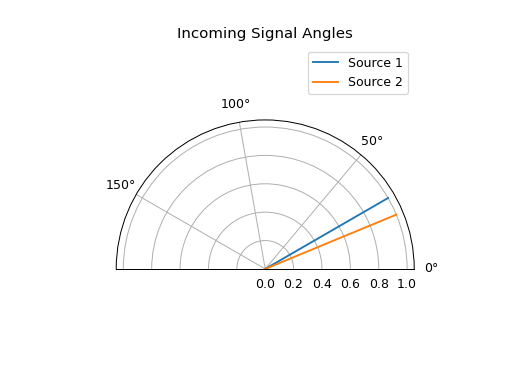

In [4]:
#Create two astronomical sources
sources = [Source(i) for i in [np.pi/6, np.pi/8]]

#Plot their positions
fig1, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_thetamin(0)
ax.set_thetamax(180)
plt.title("Incoming Signal Angles")
plt.plot([0,sources[0].phi], [0,1], label='Source 1')
plt.plot([0,sources[1].phi], [0,1], label='Source 2')
plt.legend()
plt.show()

### Antennas

In [5]:
#this class just keeps things clean
class Antenna:
    #creates an antenna with an offset of position
    def __init__(self, position):
        self.position = position

In [6]:
#create two antennas
antennas = [Antenna(i) for i in [1, -1]]

## Signal reception

<IPython.core.display.Javascript object>


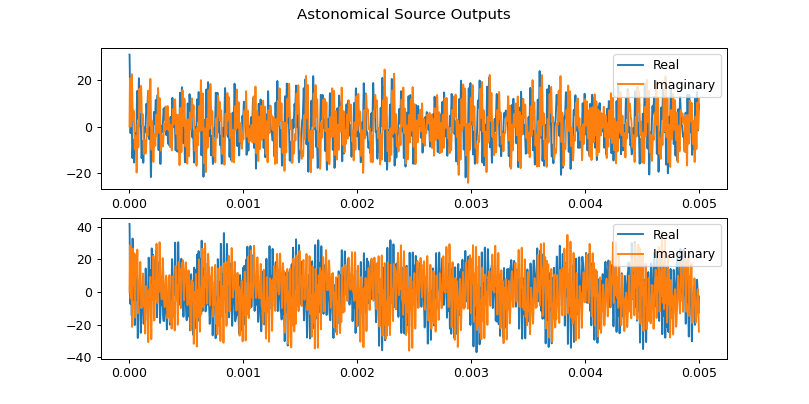

In [7]:
#calculate a time vector
t = np.arange(0, nsamples/fs, 1/fs) #1000 samples 

#Plot the signals
fig2, ax2 = plt.subplots(2, 1, figsize=(10,5))
ax2[0].plot(t, np.real(sources[0].signal(t)), label='Real')
ax2[0].plot(t, np.imag(sources[0].signal(t)), label='Imaginary')
ax2[0].legend()

ax2[1].plot(t, np.real(sources[1].signal(t)), label='Real')
ax2[1].plot(t, np.imag(sources[1].signal(t)), label='Imaginary')
ax2[1].legend()

fig2.suptitle("Astonomical Source Outputs")
plt.show()

In [8]:
#Calculate the phase shift for the second antenna
baseline = np.abs(antennas[0].position - antennas[1].position)
time_delays = [baseline * np.cos(sources[i].phi)/c for i in range(len(sources))]
max_time_delay = baseline/c

#calculate the received signals for the two antennas
a1_rx = sources[0].signal(t)# + sources[1].signal(t)
a2_rx = sources[0].signal(t+time_delays[0])# + sources[1].signal(t+time_delays[1])

In [9]:
print(max_time_delay)

6.666666666666667e-09


<IPython.core.display.Javascript object>


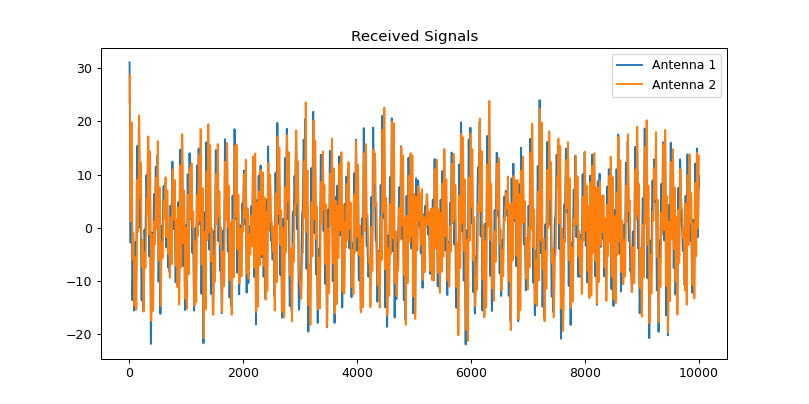

In [10]:
fig3 = plt.figure(figsize=(10,5))
plt.plot(np.real(a1_rx), label="Antenna 1")
plt.plot(np.real(a2_rx), label="Antenna 2")
plt.title("Received Signals")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


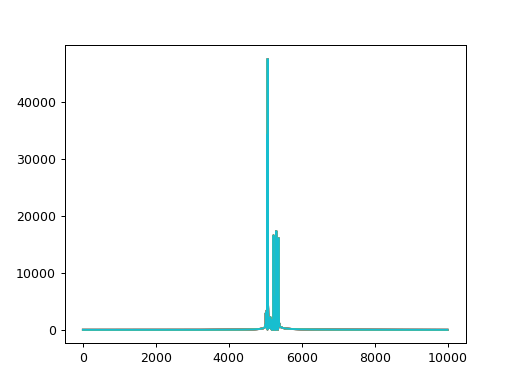

In [16]:
fig4 = plt.figure()
#first step in FC correlator - take FFTs
ft1 = np.fft.fftshift(np.fft.fft(a1_rx))
ft2 = np.fft.fftshift(np.angle(np.fft.fft(a1_rx)))
freqs = np.fft.fftshift(np.fft.fftfreq(nsamples, 1/fs))

numguesses = 2000
resultvect = np.zeros(numguesses, dtype='complex128')
for i in range(numguesses):
    #create a time shift
    shift_phase = (max_time_delay / numguesses * 2 * i - max_time_delay) * (freqs + fc) * 2 * np.pi
    shift_exp = np.exp(-1j * shift_phase)
    #apply the time shift
    guessvect = ft1 * shift_exp
    #correlate
    correlation = np.conjugate(guessvect) * ft2
    if(i % 205 == 0):
        plt.plot(np.abs(correlation))
    #accumulate
    resultvect[i] = np.sum(correlation)

#repeat

In [12]:
print(max_time_delay)

6.666666666666667e-09


<IPython.core.display.Javascript object>


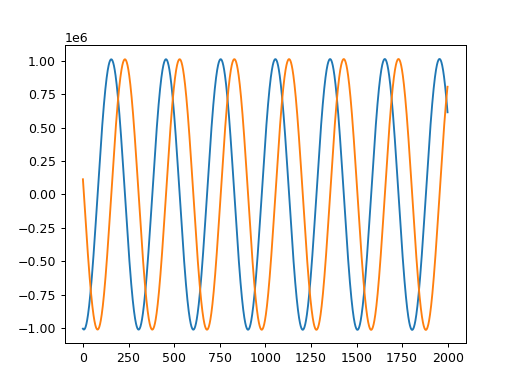

In [20]:
fig4 = plt.figure()
plt.plot(np.real(resultvect))
plt.plot(np.imag(resultvect))

In [14]:
print(time_delays)

[5.773502691896258e-09, 6.159196883408578e-09]


<IPython.core.display.Javascript object>


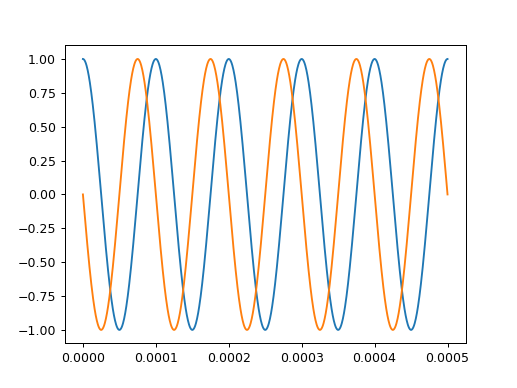

<IPython.core.display.Javascript object>


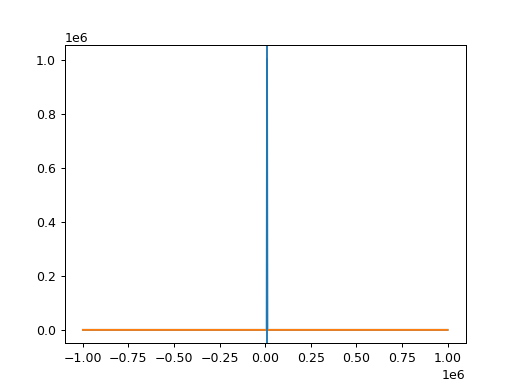

In [15]:
# a little experiment
t = np.arange(0, 1000/fs, 1/fs)
tv1 = np.exp(1j * 2 * np.pi * 10000 * t)
tv2 = np.exp(1j * (2 * np.pi * 10000 * t + np.pi/2))

fig6 = plt.figure()
plt.plot(t, np.real(tv1))
plt.plot(t, np.real(tv2))

ft1 = np.fft.fftshift(np.fft.fft(tv1))
ft2 = np.fft.fftshift(np.fft.fft(tv2))
freqs = np.fft.fftshift(np.fft.fftfreq(1001, 1/fs))
fig7 = plt.figure()
plt.plot(freqs, np.abs(ft1 * ft2))
plt.plot(freqs, np.angle(ft2))
plt.axvline(x=10000)